In [1]:
import pandas as pd
import numpy as np
import pylab 
import matplotlib.pyplot as plt
from collections import Counter
import re
import itertools
import gc

#importing packages for the prediction of time-series data
import statsmodels.api as sm
import pmdarima as pm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics import tsaplots


In [2]:
plt.rcParams['figure.figsize'] = [20, 5]

In [3]:
data =  pd.read_csv ('ETHUSDT.csv')
# data = pd.read_csv ('BTCUSDT.csv')
data.head()

,Open Time,Open Time.1,Open,High,Low,Close,Volume,Close Time,Quote Asset Volume,Number of Trades,TB Base Volume,TB Quote Volume,Ignore
0,2017-08-17,2017-08-17 00:00:00.000000000,301.13,312.18,298.00,302.00,7030.71034,2017-08-17 23:59:59.999000064,2.154655e+06,4522,6224.58999,1.908705e+06,50579.872288
1,2017-08-18,2017-08-18 00:00:00.000000000,302.00,311.79,283.94,293.96,9537.84646,2017-08-18 23:59:59.999000064,2.858947e+06,5658,7452.43542,2.240813e+06,55329.574324
2,2017-08-19,2017-08-19 00:00:00.000000000,293.31,299.90,278.00,290.91,2146.19773,2017-08-19 23:59:59.999000064,6.200226e+05,1795,1537.97550,4.447136e+05,58005.171046
3,2017-08-20,2017-08-20 00:00:00.000000000,289.41,300.53,282.85,299.10,2510.13871,2017-08-20 23:59:59.999000064,7.428479e+05,2038,2186.68739,6.475061e+05,60299.066154
4,2017-08-21,2017-08-21 00:00:00.000000000,299.10,346.52,294.60,323.29,5219.44542,2017-08-21 23:59:59.999000064,1.689472e+06,3925,4004.19967,1.297977e+06,66203.840222


In [4]:
data['Change_close'] = data['Close'].pct_change()
data['Change_close'] = data['Change_close'].fillna(0)
data['Date'] = data['Close Time'].str[:10]
data.set_index('Date',inplace=True)


In [5]:
data.head(2)

,Open Time,Open Time.1,Open,High,Low,Close,Volume,Close Time,Quote Asset Volume,Number of Trades,TB Base Volume,TB Quote Volume,Ignore,Change_close
Date,,,,,,,,,,,,,,
2017-08-17,2017-08-17,2017-08-17 00:00:00.000000000,301.13,312.18,298.00,302.00,7030.71034,2017-08-17 23:59:59.999000064,2.154655e+06,4522,6224.58999,1.908705e+06,50579.872288,0.000000
2017-08-18,2017-08-18,2017-08-18 00:00:00.000000000,302.00,311.79,283.94,293.96,9537.84646,2017-08-18 23:59:59.999000064,2.858947e+06,5658,7452.43542,2.240813e+06,55329.574324,-0.026623


In [6]:
# # Split test and train
# X = data
# train_size = int(len(X) * 0.80)
# train, test = X[0:train_size], X[train_size:]
    

In [7]:
def train_test(X):
    dataset = X[['Close','Change_close']]
    train_size = int(len(dataset) * 0.95)
    train, test = dataset[0:train_size], dataset[train_size:] 
    return train,test

In [8]:
train,test = train_test(data)

In [9]:
# # Decompose - Addictive
# from statsmodels.tsa.seasonal import seasonal_decompose
# result_add = seasonal_decompose(data['Change_close'], model = 'additive', period=365, extrapolate_trend = 'freq')



In [10]:
# # Plot
# result_add.seasonal.plot()
# plt.xticks(np.arange(0, len(data['Change_close'])+1, 5),rotation = 45)
# plt.show()

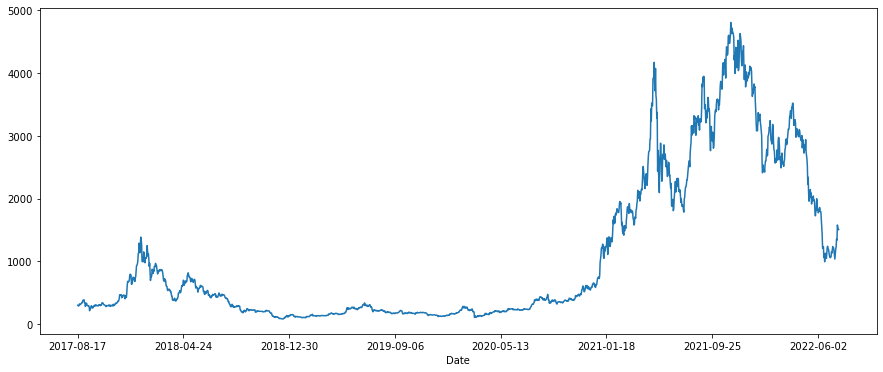

In [11]:
data.Close.plot(figsize = (15, 6))
plt.show()

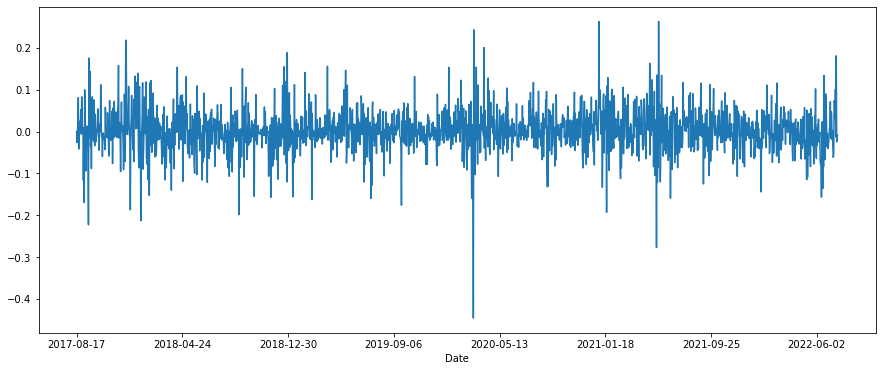

In [12]:
data.Change_close.plot(figsize = (15, 6))
plt.show()

In [13]:
from statsmodels.tsa.stattools import adfuller
def test_for_stationary(input_data):
    r_mean = input_data.rolling(window = 7,center=False).mean()
    r_std = input_data.rolling(window = 7,center=False).std()
    
    # plotting the data
    given = plt.plot(input_data, color = 'blue', label = 'given_series')
    rolling_mean = plt.plot(r_mean, color = 'red', label = 'rolling_mean')
    rolling_std = plt.plot(r_std, color ='green', label = 'rolling_std')
    plt.legend(loc = 'best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
     #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(input_data)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [14]:
# test_for_stationary(train['Change_close'])

In these plot, the two dotted lines on either sides of 0 are the confidence interevals. These can be used to determine the ‘p’ and ‘q’ values as: the Lag values are identified from PACF and ACF plots for Autoregression(AR) and Moving Average(MA) parameters, p and q respectively p – The lag value where the PACF chart crosses the upper confidence interval for the first time. If you notice closely, in this case p=2, The PACF shows a significant lag on day 2

In [15]:
# Plot ACF (Auto Correlation)
# acf_plot = plot_acf(data.Close, lags = 40)

In [16]:
# pacf_plot = plot_pacf(data.Close, lags = 30)

In [17]:
# Accuracy of the model
def performance(y_true, y_pred): 
    mse = ((y_pred - y_true) ** 2).mean()
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return( print('MSE of predictions is {}'.format(round(mse, 2))+
                  '\nRMSE of predictions is {}'.format(round(np.sqrt(mse), 2))+
                  '\nMAPE of predictions is {}'.format(round(mape, 2))))

In [18]:
def arima_process(train,test):
    #ARIMA
    model_AR = ARIMA(train['Change_close'], order = (7, 1, 0))
    model_arima_fit = model_AR.fit() 
    real_data = train['Change_close']
    pred = model_arima_fit.fittedvalues
    
    # Plot
    plt.plot(real_data, label = 'Original Series') 
    plt.plot(pred, color = 'black', label = 'Predictions')
    plt.xticks(np.arange(0, len(train['Change_close'])+1, 50),rotation = 45)
    plt.legend(loc = 'best') 
    plt.show()
    
    # Summary
    print(model_arima_fit.summary())
    forecast_values = model_arima_fit.forecast(len(test), alpha = 0.05) 
    test['forecast_ARIMA'] = forecast_values
    
    # Plot
    plt.plot(test['Change_close'], label = 'Actual') 
    plt.plot(test['forecast_ARIMA'], color = 'black', label = 'Predictions')
    plt.xticks(np.arange(0, len(test['Change_close'])+1, 5),rotation = 45)
    plt.legend(loc = 'best') 
    plt.show()
    
    test['PR_Close_ARIMA']  = test['forecast_ARIMA'].add(1,fill_value=0).cumprod()*train['Close'].iat[-1]
    
    # Plot
    plt.plot(test['Close'], label = 'Actual') 
    plt.plot(test['PR_Close_ARIMA'], color = 'black', label = 'Predictions')
    plt.xticks(np.arange(0, len(test['Close'])+1, 5),rotation = 45)
    plt.legend(loc = 'best') 
    plt.show()
    
    # Performance
    arima_results = performance(test['Close'].values, test['PR_Close_ARIMA'].values)
    print(arima_results)
    
    

In [19]:
# # Grid Search to find the best model
# model_sarima = pm.auto_arima(train['Change_close'],
#                           seasonal = True, 
#                           m = 365,
#                           d = 0,
#                           D = 1,
#                           max_p = 2, 
#                           max_q = 2,
#                           trace = True,
#                           error_action = 'ignore',
#                           suppress_warnings = True)

In [20]:
# Best model:  ARIMA(2,0,0)(2,1,0)[12]          
# Total fit time: 164.499 seconds

In [21]:
train.tail(1)

,Close,Change_close
Date,,
2022-04-22,2962.39,-0.007102


In [22]:
test.head(2)

,Close,Change_close
Date,,
2022-04-23,2933.03,-0.009911
2022-04-24,2921.00,-0.004102


In [53]:
def data_prophet(train):
    
    train_prophet = train

    train_prophet["ds"] = train_prophet.index
    train_prophet=train_prophet.reset_index()
    train_prophet= train_prophet.drop(columns=['Date','Close'])
    train_prophet = train_prophet.rename(columns={"Change_close": "y"})
    train_prophet = train_prophet[['ds','y']]
    
    
    return train_prophet
    

In [54]:
train_prophet= data_prophet(train)
train_prophet.head()

,ds,y
0,2017-08-17,0.000000
1,2017-08-18,-0.026623
2,2017-08-19,-0.010376
3,2017-08-20,0.028153
4,2017-08-21,0.080876


In [55]:
from prophet import Prophet as proph

In [62]:
# Fitting and training
mod = proph(interval_width=0.80, growth = 'linear', daily_seasonality=False, 
            seasonality_mode = 'multiplicative')


In [63]:
mod.fit(train_prophet)

/Users/ishantchaudhary/Anaconda/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -14.0553
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      78       2804.05   9.74362e-05       76.9214   1.184e-06       0.001      152  LS failed, Hessian reset 
      99       2804.05   4.78878e-06       70.4547       0.376           1      178   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     110       2804.08   0.000278636       67.8529   3.265e-06       0.001      237  LS failed, Hessian reset 
     148       2804.11    9.9776e-06       82.5895   1.134e-07       0.001      314  LS failed, Hessian reset 
     160       2804.11   8.94119e-08       70.5682      0.2914      0.2914      331   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


In [64]:
future = mod.make_future_dataframe(periods=61, freq='D')

future.tail()
future['floor']=0

In [65]:
forecast = mod.predict(future)
forecast[['ds','yhat','yhat_lower','yhat_upper']]

/Users/ishantchaudhary/Anaconda/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/ishantchaudhary/Anaconda/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


,ds,yhat,yhat_lower,yhat_upper
0,2017-08-17,0.001427,-0.065484,0.069031
1,2017-08-18,0.001450,-0.064659,0.065745
2,2017-08-19,0.001453,-0.066294,0.070937
3,2017-08-20,0.001440,-0.064675,0.069517
4,2017-08-21,0.001444,-0.065655,0.066584
...,...,...,...,...
1766,2022-06-18,0.002296,-0.061560,0.067183
1767,2022-06-19,0.002275,-0.066305,0.071665
1768,2022-06-20,0.002279,-0.069728,0.062801
1769,2022-06-21,0.002257,-0.065729,0.073208


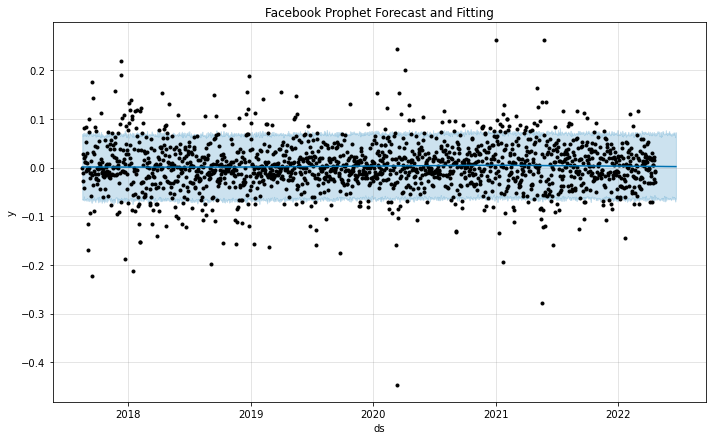

In [66]:
mod.plot(forecast, uncertainty=True)
plt.title('Facebook Prophet Forecast and Fitting')
plt.show()

/Users/ishantchaudhary/Anaconda/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/ishantchaudhary/Anaconda/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


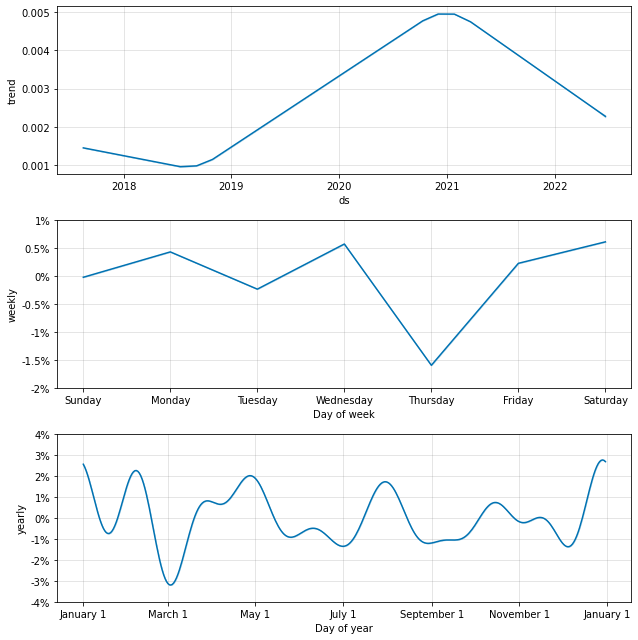

In [67]:
mod.plot_components(forecast)
plt.show()